### 課題1
以下の小問の(1)-(2)を解答せよ．

1. OptimizerをモーメンタムSDG (momentum=0.9), RMSprop, Adamに変更して，ノーマルなSDGとの違いを観察せよ．
1. 関数 $f(x)$ を自由に書き換え，実行せよ．2通りの $f(x)$ で試してみよ．

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# カレントディレクトリの読み込みとカレントディレクトリへの移動
import sys
sys.path.append(f'/content/drive/My Drive/system/')
import os
os.chdir(f'/content/drive/My Drive/system/myanswer')

In [ ]:
import numpy as np
import time

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

In [ ]:
def f(x):
    return 0.5*(x-2)**2-5

def f2(x):
    return 0.5*(x + 3)**2 - 8

def f3(x):
    return np.sin(x)/x

In [ ]:
def generate_function_and_train_test_data(pattern = "1"):
    if pattern == "1":
        X_train = np.arange(-10,10,0.01,dtype=np.float32)
        Y_train = f(X_train)
        # X_train, Y_trainは１次元配列なので，reshapeで ２次元の(n,dim)に変換します．dim=1です．
        X_train = np.reshape(X_train,[-1,1])   # (2000,)  -> (2000,1)
        Y_train = np.reshape(Y_train,[-1,1]) 
        num_train = np.size(X_train)

        # テスト用の x も準備します．
        X_val = np.arange(-8,8,0.1,dtype=np.float32)
        Y_val = f(X_val)
        X_val = np.reshape(X_val,[-1,1])
        Y_val = np.reshape(Y_val,[-1,1])
        num_val = np.size(X_val)
        
        return X_train, Y_train, X_val, Y_val, f
    
    elif pattern == "2":
        X_train = np.arange(-10,10,0.01,dtype=np.float32)
        Y_train = f2(X_train)
        # X_train, Y_trainは１次元配列なので，reshapeで ２次元の(n,dim)に変換します．dim=1です．
        X_train = np.reshape(X_train,[-1,1])   # (2000,)  -> (2000,1)
        Y_train = np.reshape(Y_train,[-1,1]) 
        num_train = np.size(X_train)

        # テスト用の x も準備します．
        X_val = np.arange(-8,8,0.1,dtype=np.float32)
        Y_val = f(X_val)
        X_val = np.reshape(X_val,[-1,1])
        Y_val = np.reshape(Y_val,[-1,1])
        num_val = np.size(X_val)
        
        return X_train, Y_train, X_val, Y_val, f2
    
    elif pattern == "3":
        X_train = np.arange(-10,10,0.01,dtype=np.float32)
        Y_train = f3(X_train)
        # X_train, Y_trainは１次元配列なので，reshapeで ２次元の(n,dim)に変換します．dim=1です．
        X_train = np.reshape(X_train,[-1,1])   # (2000,)  -> (2000,1)
        Y_train = np.reshape(Y_train,[-1,1]) 
        num_train = np.size(X_train)

        # テスト用の x も準備します．
        X_val = np.arange(-8,8,0.1,dtype=np.float32)
        Y_val = f(X_val)
        X_val = np.reshape(X_val,[-1,1])
        Y_val = np.reshape(Y_val,[-1,1])
        num_val = np.size(X_val)
        
        return X_train, Y_train, X_val, Y_val, f3

In [ ]:
def fullconnection_model(optimizer="sgd"):
    model = Sequential()
    model.add(Dense(20, input_dim=1, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
      
    if optimizer == "sgd":
        sgd = keras.optimizers.SGD(lr=0.0001, momentum=0, decay=0.0)
        model.compile(optimizer=sgd, loss='mean_squared_error')
    elif optimizer == "momentum_sgd":
        momentum_sgd = keras.optimizers.SGD(lr=0.0001, momentum=0.9, decay=0)
        model.compile(optimizer=momentum_sgd, loss='mean_squared_error')
    elif optimizer == "rmsprop":
        rmsprop = keras.optimizers.RMSprop()
        model.compile(optimizer=rmsprop, loss='mean_squared_error')
    elif optimizer == "adam":
        adam = keras.optimizers.Adam()
        model.compile(optimizer=adam, loss='mean_squared_error')

    return model

In [ ]:
model = fullconnection_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 20)                40        
_________________________________________________________________
dense_13 (Dense)             (None, 20)                420       
____________________________________

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import keras

# callback のクラス ShowGraphを定義
# グラフ表示で必要なので，コンストラクタで，model, 最大エポック数 を受け取っておく．
# model は，学習途中のパラメータを用いて， y=f(x)を描画するのに必要．
class ShowGraph(keras.callbacks.Callback):
    def __init__(self,model,max_epoch, pattern, X_val, f, optimizer):
        # 表示エリアの設定
        self.fig = plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0, 50])
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([-8,8,-10,30])
        self.fig1.set_title('loss')
        self.fig1.set_ylabel('loss')
        self.fig1.set_xlabel('epoch')
        self.model = model
        self.max_epoch = max_epoch
        self.start = time.time()
        self.pattern = pattern
        self.X_val = X_val
        self.f = f
        self.optimizer = optimizer
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses = []
        self.losses_val = []
        self.n_epoch = []
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, logs={}):
        self.n_epoch.append(epoch)
        self.losses.append(logs.get('loss'))
        self.losses_val.append(logs.get('val_loss'))     
        self.loss_val = logs.get('val_loss')
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.losses,"b", label="train loss")
        self.fig1.plot(self.n_epoch,self.losses_val,"r", label="validation loss")
        self.fig1.legend(loc="upper right")
        Y_pred = self.model.predict_on_batch(self.X_val)
        x0 = np.reshape(X_val,[-1])
        y0 = np.reshape(Y_pred,[-1])
        self.fig2.plot(x0,y0,"b", label="fitting result")
        self.fig2.plot(x0,self.f(x0),"r", label="ground truth")
        if self.pattern == "1":
            self.fig2.set_title('y = 0.5(x-2)^2 - 5')
        elif self.pattern == "2":
            self.fig2.set_title('y = 0.5(x+3)^2 - 8')
        elif self.pattern == "3":
            self.fig2.set_title('y = sin(x)/x')
        self.fig2.legend(loc="upper right")
        self.fig2.set_ylabel('f(x)')
        self.fig2.set_xlabel('x')
        display.display(self.fig)
        if epoch < self.max_epoch - 1:
            self.fig1.cla()
            self.fig2.cla()
    
    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val loss値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        # 実行結果の画像を保存
        self.fig.savefig("../result/function_fitting/function_fitting_pattern{}_{}.png".format(self.pattern, self.optimizer),
                         transparent=True, dpi=300, bbox_inches="tight", pad_inches=0.0)
        print("loss_val: {}".format(self.loss_val)) 
        print('Time: {}'.format(time.time() - self.start))

### 課題1. 1 OptimizerをモーメンタムSDG (momentum=0.9), RMSprop, Adamに変更して，ノーマルなSDGとの違いを観察せよ．

In [ ]:
X_train, Y_train, X_val, Y_val, f = generate_function_and_train_test_data()
num_epoch = 50

### ノーマルなSGDを利用した場合

loss_val: 4.361052513122559
Time: 21.80350375175476


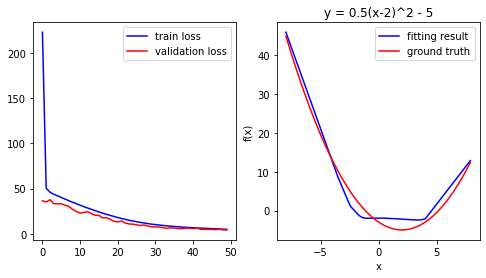

In [ ]:
show_graph = ShowGraph(model,num_epoch, pattern="1", X_val=X_val, f=f, optimizer="sgd")
model.fit(X_train, Y_train, batch_size=20, epochs=num_epoch, 
          validation_data=(X_val,Y_val), verbose=0, callbacks=[show_graph])
del show_graph

### モーメンタムSGDを利用した場合

loss_val: 0.028856173157691956
Time: 21.531312704086304


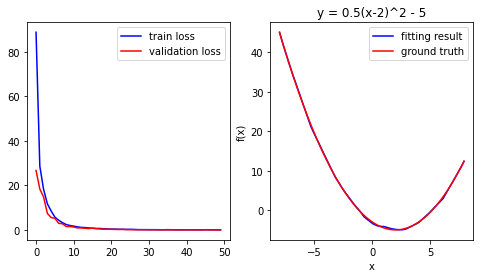

In [ ]:
model_momentumsgd = fullconnection_model(optimizer="momentum_sgd")
show_graph = ShowGraph(model_momentumsgd, num_epoch, pattern="1", 
                       X_val=X_val, f=f, optimizer="momentumsgd")
model_momentumsgd.fit(X_train, Y_train, batch_size=20, epochs=num_epoch, 
                      validation_data=(X_val,Y_val), verbose=0, callbacks=[show_graph])
del show_graph

### RMSprop を利用した場合

loss_val: 0.04130428284406662
Time: 21.886054515838623


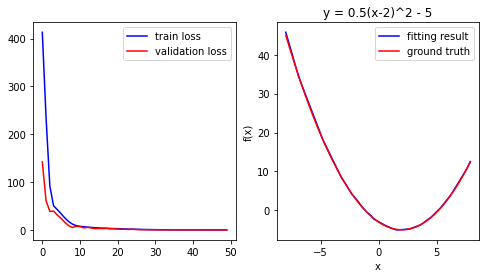

In [ ]:
model_rmsprop = fullconnection_model(optimizer="rmsprop")
show_graph = ShowGraph(model_rmsprop, num_epoch, pattern="1", 
                       X_val=X_val, f=f, optimizer="rmsprop")
model_rmsprop.fit(X_train, Y_train, batch_size=20, epochs=num_epoch, 
                      validation_data=(X_val,Y_val), verbose=0, callbacks=[show_graph])
del show_graph

### Adamを利用した場合

loss_val: 0.07992731034755707
Time: 21.65705919265747


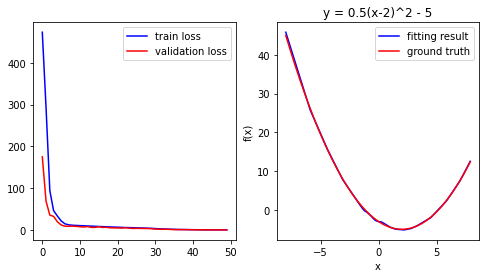

In [ ]:
model_adam = fullconnection_model(optimizer="adam")
show_graph = ShowGraph(model_momentumsgd, num_epoch, pattern="1", 
                       X_val=X_val, f=f, optimizer="adam")
model_adam.fit(X_train, Y_train, batch_size=20, epochs=num_epoch, 
                      validation_data=(X_val,Y_val), verbose=0, callbacks=[show_graph])
del show_graph

### 課題1 2. 関数  𝑓(𝑥)  を自由に書き換え，実行せよ．2通りの  𝑓(𝑥)  で試してみよ

$f(x)= 0.5\times(x+3)^2 - 8$ ，勾配の更新方法はSGDとする

loss_val: 347.2373962402344
Time: 21.754323720932007


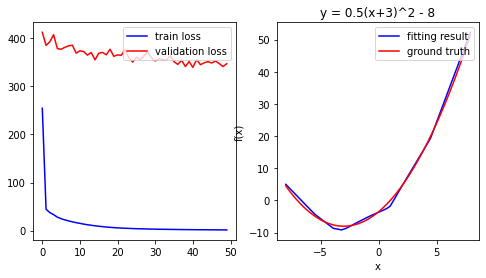

In [ ]:
X_train, Y_train, X_val, Y_val, f = generate_function_and_train_test_data(pattern="2")

show_graph = ShowGraph(model, num_epoch, pattern="2", 
                       X_val=X_val, f=f, optimizer="sgd")
model.fit(X_train, Y_train, batch_size=20, epochs=num_epoch, 
          validation_data=(X_val,Y_val), verbose=0, callbacks=[show_graph])
del show_graph

$f(x) = \dfrac{\sin(x)}{x}$ ，勾配の更新方法はSGDとする．

loss_val: 323.8036193847656
Time: 21.60598850250244


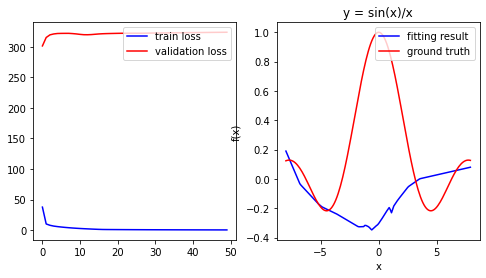

In [ ]:
X_train, Y_train, X_val, Y_val, f = generate_function_and_train_test_data(pattern="3")

show_graph = ShowGraph(model, num_epoch, pattern="3", 
                       X_val=X_val, f=f, optimizer="sgd")
model.fit(X_train, Y_train, batch_size=20, epochs=num_epoch, 
          validation_data=(X_val,Y_val), verbose=0, callbacks=[show_graph])
del show_graph